In [528]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math 

In [515]:
# sampling x 
x1 = np.random.normal(3 , 2, (1000000,) ) 
x2 = np.random.normal(-1, 2 , (1000000,)) 
x = np.zeros((1000000, 3)) 

x[:, 0] = 1 # adding intercept term 
x[:, 1] = x1 
x[:, 2] = x2 
# print(np.var(x[:, 1]))  

# sampling y 

original_hypothesis = np.array([3,1,2]) 
y = np.matmul(x, original_hypothesis) 
y += np.random.normal(0, math.sqrt(2) , y.shape)  
# print(np.mean(y)) 



In [516]:
def compute_batch_error(X, Y, theta, batch_size, batch_number):
    X_batch = X[batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size, :] 
    Y_batch = Y[ batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size] 

    Z = Y_batch - np.matmul(X_batch, theta)
    error = np.matmul(np.transpose(Z), Z) / (2 * batch_size) 
    return error  

In [517]:
def compute_batch_gradient(X, Y, theta, batch_size, batch_number):
    X_batch = X[batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size, :] 
    Y_batch = Y[ batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size] 
    Z_batch = Y_batch - np.matmul(X_batch, theta) 
    # print(Z)
    gradient = np.zeros(theta.size) 
    for j in range(theta.size):
        X_j = X_batch[:, j] 
        gradient[j] = np.sum(Z_batch * X_j)/ batch_size 
    return gradient

In [518]:
def compute_error(X, Y, hypothesis):
    Z = (Y - np.matmul(X, hypothesis)) 
    m = Y.size 
    error = np.matmul(np.transpose(Z), Z)/ (2 * m) 
    return error 

In [519]:
def minibatch_gradient_descent(X, Y, batch_size, k, gamma):
    current_batch_number = 1 
    theta = np.zeros(X[0].size) 
    # print(theta) 
    initial_error = compute_batch_error(X, Y, theta,  batch_size, int(current_batch_number) ) 
    epsilon = 0.000001 * initial_error 
    # epsilon = 1e-5
    # print(f"factor is {pow(batch_size, -0.5)}")
    #we decrease epsilon for large batch sizes, since smaller batch sizes converge more noisily to the 
    # optima, thus they require a larger epsilon 
     
    epsilon = pow(batch_size, -0.5) * epsilon 
    max_count = int(1/epsilon) 
    # to avoid oscillations, we introduce this cap  


    learning_parameter = 0.001
    MOD = Y.size / batch_size 
    max_count = max(max_count, MOD)  
    print(f"maxcount is {max_count}")
    no_of_iterations = 0 


    error_arr = []
    running_avg = 0 
    previous_running_avg = 0 

    for i in range(k):
        grad = compute_batch_gradient(X, Y, theta, batch_size, int(current_batch_number) ) 
        theta = theta + learning_parameter * grad 
        # curr_error = compute_batch_error(X, Y,theta,  batch_size, int(current_batch_number) )
        curr_error = compute_error(X, Y, theta) 
        error_arr.append(curr_error) 
        running_avg += curr_error 
        current_batch_number = (current_batch_number + 1) 
        if (current_batch_number > MOD):  current_batch_number -= MOD 
        # no_of_iterations += 1


    running_avg /= k
    last_count = 0  # no of consecutive times difference in averages is less than epsilon  
    # epsilon = 0.000001 * running_avg 
    
    while (last_count < gamma and no_of_iterations < max_count):
        
        
        previous_running_avg = running_avg 
        previous_error = error_arr.pop(0) 

        # print(f" batch size, batch num {batch_size} {current_batch_number}") 
        grad = compute_batch_gradient(X, Y, theta, batch_size, int(current_batch_number) ) 
        theta = theta + learning_parameter * grad 
        
        # curr_error = compute_batch_error(X, Y,theta,  batch_size, int(current_batch_number) ) 
        curr_error = compute_error(X, Y, theta)
        error_arr.append(curr_error) 

        running_avg = running_avg + (curr_error - previous_error)/k  

        # print(f"current theta is {theta}") 
        # print(f"last count {last_count}")
        # print(f"average error is {running_avg}") 
        
        if (abs(previous_running_avg - running_avg) < epsilon) :  last_count += 1 
        else: last_count = 0
        
        no_of_iterations += 1 
        current_batch_number = (current_batch_number + 1) 
        if (current_batch_number > MOD):  current_batch_number -= MOD 

    print(f"no of iterations is {no_of_iterations}") 
    # print(f"learned theta is {theta}") 
    return theta 
    

In [520]:
# model1 = minibatch_gradient_descent(x , y , 1, 10,1) 
# error1 = compute_error(test_input, test_output, model1) 
# print("model1 error1", model1, error1 )
# model2 = minibatch_gradient_descent(x, y, 100, 10,1)   
# error2 = compute_error(test_input, test_output, model2) 
# print("model2 error2", model2, error2) 
# # model3 = minibatch_gradient_descent(x, y , 10000, 5,1) 
# # model4 = minibatch_gradient_descent(x, y, 1000000, 1,1) 

In [521]:
def minibatch_v2(X, Y, batch_size, k, gamma):
    # np.random.shuffle(X) 
    # here i compute difference of two consecutive sets of k iterations 
    current_batch_number = 1 
    theta = np.zeros(X[0].size) 
    # print(theta) 
    # initial_error = compute_batch_error(X, Y, theta,  batch_size, int(current_batch_number) )
    initial_error = compute_error(X, Y, theta) 
    # epsilon = 0.000001 * initial_error  
    epsilon = 5e-5 
    print(f"epsilon is {epsilon}")
    #we decrease epsilon for large batch sizes, since smaller batch sizes converge more noisily to the 
    # optima, thus they require a larger epsilon 
     
    # epsilon = pow(batch_size, -0.5) * epsilon 
    # max_count = int(1/epsilon) 
    # to avoid oscillations, we introduce this cap  


    learning_parameter = 0.001
    MOD = Y.size / batch_size 
    # max_count = max(max_count, MOD)  
    # print(f"maxcount is {max_count}")
    no_of_iterations = 0 

    previous_avg_error = 0 
    avg_error = 0 
    last_count = 0 
    
    # max_count = int(80 * MOD) 
    max_count = max(1e4, 100 * MOD) 
    point_list = [] 
    print(max_count) 
    while (True):
        previous_avg_error = avg_error 
        avg_error = 0 
        for i in range(k):
            grad = compute_batch_gradient(X, Y, theta, batch_size, int(current_batch_number) ) 
            theta = theta + learning_parameter * grad  
            point_list.append(theta) 
            curr_error = compute_batch_error(X, Y, theta, batch_size, int(current_batch_number))  
            # curr_error = compute_error(X, Y, theta) 
            avg_error += curr_error 
            no_of_iterations += 1 
            current_batch_number = (current_batch_number + 1) 
            if (current_batch_number > MOD):  current_batch_number -= MOD 
        avg_error /= k         
        print(f"theta : {theta}") 
        print(f"avg_error last_count {avg_error} {last_count} ")
        if (abs(avg_error - previous_avg_error) <  epsilon): last_count += 1 
        else : last_count = 0 
        if (last_count >= gamma or no_of_iterations > max_count): break 
    
    print(f"no of iterations is {no_of_iterations}") 
    print(f"learned theta is {theta}") 
    return (theta, point_list)
    

In [522]:
test_set = pd.read_csv("./ass1_data/data/q2/q2test.csv") 
test_set = test_set.to_numpy() 
temp = np.zeros((10000, 4)) 
temp[:,0] = 1 
temp[:, 1] = test_set[:, 0] 
temp[:, 2] = test_set[:, 1] 
temp[:, 3] = test_set[:, 2]

test_set = temp 

# print(test_set) 

test_input = test_set[:, 0 : 3] 
test_output = test_set[:, 3] 

(model1, list1) = minibatch_v2(x, y, 1, 10, 1) 
error1 = compute_error(test_input, test_output, model1) 
print(f"model1  error1  {model1}  | {error1}")

(model2, list2) = minibatch_v2(x, y, 100, 10, 1) 
error2 = compute_error(test_input, test_output, model2) 
print(f"model2  error2  {model2}  | {error2}")

(model3, list3) = minibatch_v2(x, y, 10000, 10 ,10) 
error3 = compute_error(test_input, test_output, model3) 
print(f"model3  error3  {model3}  | {error3}")

(model4, list4) = minibatch_v2(x, y, 1000000, 1, 1) 
error4 = compute_error(test_input, test_output, model4) 
print(f"model4  error4  {model4}  | {error4}")





epsilon is 5e-05
100000000.0
theta : [0.04654738 0.15798357 0.03530445]
avg_error last_count 18.269357348300808 0 
theta : [0.10919315 0.39265124 0.14541843]
avg_error last_count 27.25260983407813 0 
theta : [0.14004777 0.4813793  0.13384241]
avg_error last_count 6.214337169772316 0 
theta : [0.17767362 0.61126952 0.19318711]
avg_error last_count 14.196509547445794 0 
theta : [0.20166464 0.68526078 0.27020704]
avg_error last_count 10.925989987343439 0 
theta : [0.22340734 0.74009639 0.28846723]
avg_error last_count 6.222519540005093 0 
theta : [0.24212778 0.8230861  0.38075755]
avg_error last_count 11.38306493280657 0 
theta : [0.26176121 0.88833987 0.39175632]
avg_error last_count 4.763512372144861 0 
theta : [0.27344132 0.91448044 0.49424473]
avg_error last_count 9.78418788996769 0 
theta : [0.2784042  0.91998425 0.56880316]
avg_error last_count 8.008109973295031 0 
theta : [0.28795088 0.94949452 0.57834879]
avg_error last_count 2.023037979963011 0 
theta : [0.29635617 0.95773879 0.6

theta : [1.89596952 1.25501082 1.9126828 ]
avg_error last_count 1.5989541197059742 0 
theta : [1.89688172 1.24774259 1.89775369]
avg_error last_count 0.6331748818067133 0 
theta : [1.90447931 1.26453462 1.9065043 ]
avg_error last_count 0.7304067719293063 0 
theta : [1.90633059 1.25481326 1.9018878 ]
avg_error last_count 0.8361948568587287 0 
theta : [1.90886219 1.25416698 1.9139437 ]
avg_error last_count 1.208486084013559 0 
theta : [1.90801644 1.25430222 1.91291887]
avg_error last_count 0.47619445412375566 0 
theta : [1.91025426 1.24324662 1.89169175]
avg_error last_count 1.7009725126055244 0 
theta : [1.90718696 1.22663337 1.90828826]
avg_error last_count 0.6019440627903059 0 
theta : [1.90651782 1.21579328 1.91192566]
avg_error last_count 0.738963900391883 0 
theta : [1.91180391 1.22538402 1.90604612]
avg_error last_count 0.4361939786411503 0 
theta : [1.91800708 1.22719588 1.91093754]
avg_error last_count 1.1647231770501052 0 
theta : [1.91876692 1.1980865  1.9141742 ]
avg_error la

In [523]:


og_error1 = compute_error(test_input, test_output, original_hypothesis) 

print("error wrt original model") 
print(og_error1) 


error wrt original model
0.9829469215


In [529]:
def plot_theta_movement(plot_list):
    plot_list = np.array(plot_list) 
    x = plot_list[:,0] 
    y = plot_list[:, 1] 
    z = plot_list[:, 2] 
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z) 

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z') 

    ax.set_title('Movement of Theta') 
    plt.show()


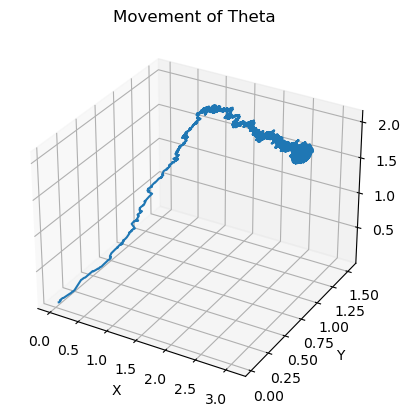

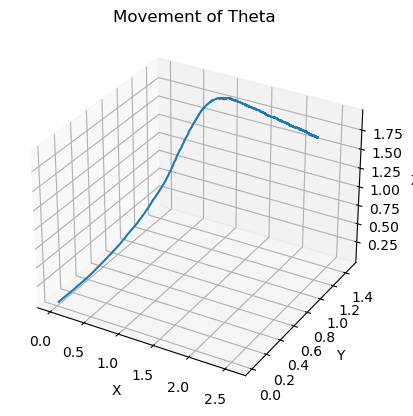

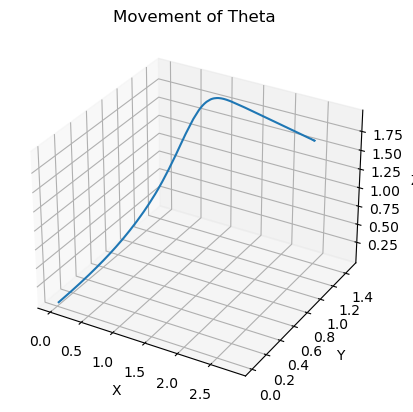

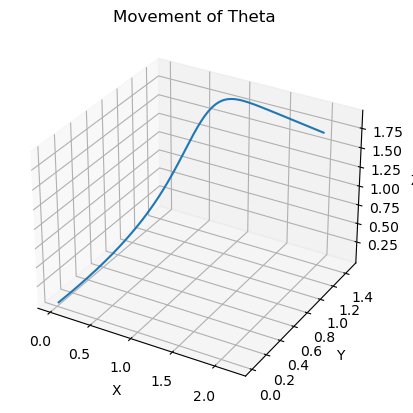

In [530]:
plot_theta_movement(list1)
plot_theta_movement(list2)
plot_theta_movement(list3)
plot_theta_movement(list4)